# Multinomial CNN

### Loading packages 

In [1]:
# For Data Processing
import numpy as np
import pandas as pd
import os
import random
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance

# For ML Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import sklearn.metrics as metrics
from tensorflow.keras import regularizers
import shap
from sklearn.metrics import recall_score

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

C:\Users\jpjon\anaconda3\envs\brain2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Paths to data directories
train_dir = './Training'
test_dir = './Testing'

#Pull in training data
train_paths = []
train_labels = []

#getting the paths and labels of our training data
for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+'/'+label):
        train_paths.append(train_dir+'/'+label+'/'+image)
        train_labels.append(label)
train_paths, train_labels = shuffle(train_paths, train_labels)

# Pull in testing data
test_paths = []
test_labels = []

#getting the paths and labels of our training data
for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+'/'+label):
        test_paths.append(test_dir+'/'+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## EDA

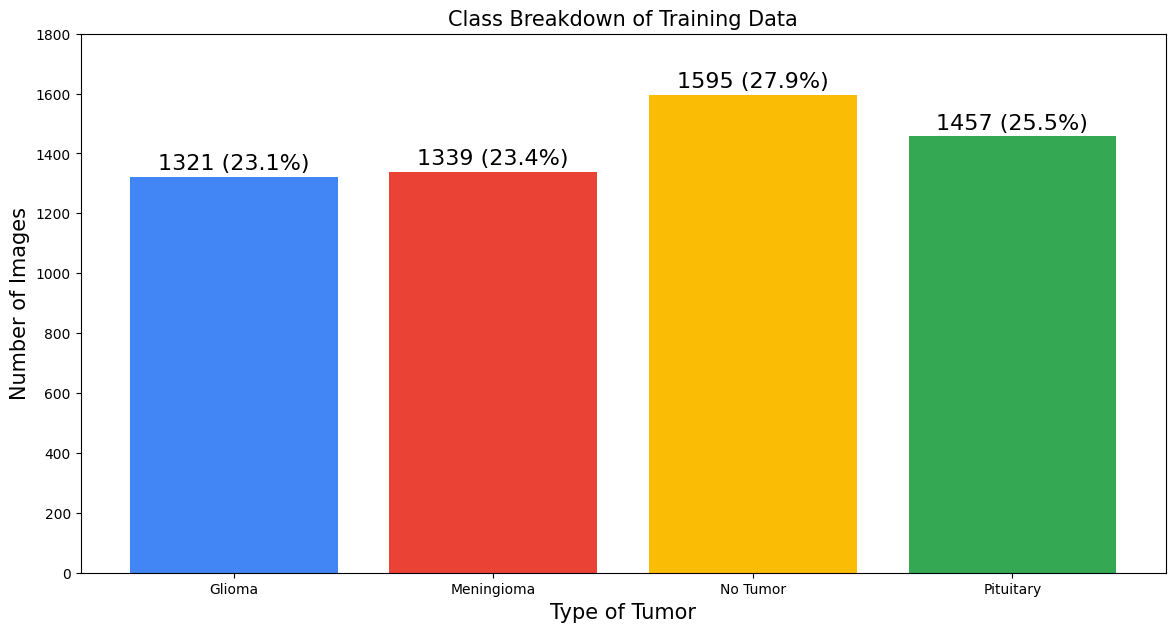

In [3]:
plt.figure(figsize=(14,7))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']

keys, counts = np.unique(train_labels, return_counts=True)

# Add text on top of each bar
for i, count in enumerate(counts):
    percent = count / counts.sum() * 100
    plt.text(i, count+25, f"{count} ({percent:.1f}%)", ha='center', fontsize=16)

plt.bar(["Glioma", "Meningioma", "No Tumor", "Pituitary"], counts, color = colors)
plt.xlabel("Type of Tumor", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.title("Class Breakdown of Training Data", fontsize=15)
plt.ylim(0, 1800)
plt.show()

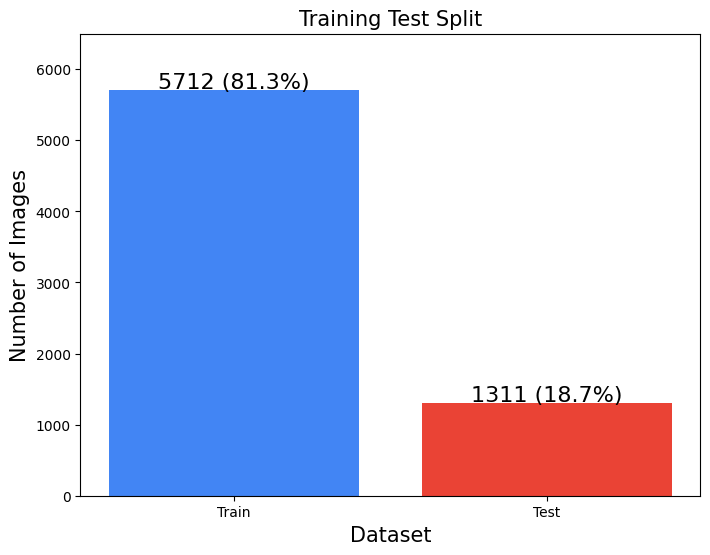

In [4]:
plt.figure(figsize=(8,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']

for i, count in enumerate([len(train_labels), len(test_labels)]):
    percent = count / (len(train_labels) + len(test_labels)) * 100
    plt.text(i, count+15, f"{count} ({percent:.1f}%)", ha='center', fontsize=16)

plt.bar(x = ["Train", "Test"], height = [len(train_labels), len(test_labels)], color = colors)
plt.xlabel("Dataset", fontsize=15)
plt.ylabel("Number of Images", fontsize = 15)
plt.ylim(0,6500)
plt.title("Training Test Split", fontsize = 15)
plt.show()

In [5]:
#Encoding used for both dataframes
encoding = {'meningioma':2, 'glioma':1, 'notumor':0, 'pituitary':3}

train_df = pd.DataFrame({'id':train_paths, 'diagnosis':train_labels})
train_df['labels'] = train_df['diagnosis'].map(encoding)


test_df = pd.DataFrame({'id':test_paths, 'diagnosis':test_labels})
test_df['labels'] = test_df['diagnosis'].map(encoding)

In [6]:
print('Shape of labels:', train_df.shape)
print('Unique diagnosis codes:', np.sort(train_df.diagnosis.unique()))
train_df.head()

Shape of labels: (5712, 3)
Unique diagnosis codes: ['glioma' 'meningioma' 'notumor' 'pituitary']


,id,diagnosis,labels
0,./Training/notumor/Tr-no_0711.jpg,notumor,0
1,./Training/pituitary/Tr-pi_0917.jpg,pituitary,3
2,./Training/notumor/Tr-no_1468.jpg,notumor,0
3,./Training/meningioma/Tr-me_0527.jpg,meningioma,2
4,./Training/notumor/Tr-no_1374.jpg,notumor,0


In [7]:
print('Shape of labels:', test_df.shape)
print('Unique diagnosis codes:', np.sort(test_df.diagnosis.unique()))
test_df.head()

Shape of labels: (1311, 3)
Unique diagnosis codes: ['glioma' 'meningioma' 'notumor' 'pituitary']


,id,diagnosis,labels
0,./Testing/glioma/Te-glTr_0003.jpg,glioma,1
1,./Testing/notumor/Te-no_0169.jpg,notumor,0
2,./Testing/meningioma/Te-me_0143.jpg,meningioma,2
3,./Testing/glioma/Te-gl_0037.jpg,glioma,1
4,./Testing/notumor/Te-no_0239.jpg,notumor,0


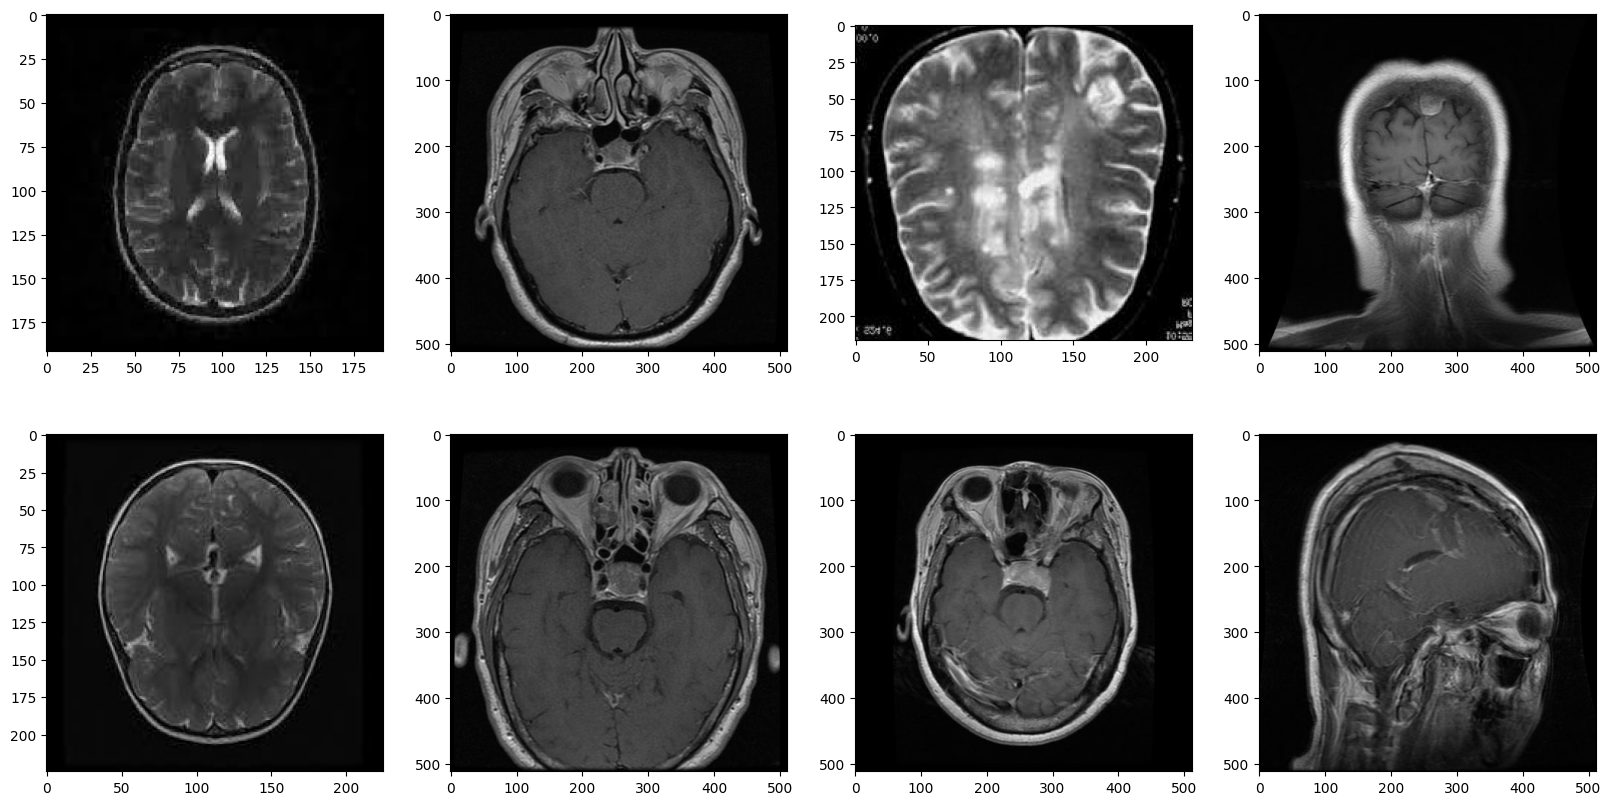

In [8]:
#check first few images of training set
images = []
for idx, img in enumerate(train_df.id):
    img = load_img(
    img)
    images.append(img)
    
nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
indx = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(images[indx])
        indx += 1

In [9]:
np.random.seed(1)

#balances training data by randomly drawing 1595 out of the three tumors
train_balance = train_df[train_df['labels'].isin([0])].sample(n=1400, replace=False, random_state=42)
#replacing all tumors with 1
#adding notumor and "1"'s together
train_balance = pd.concat([train_balance, train_df[train_df['labels'] != 0]])
train_balance = shuffle(train_balance)

train_balance.labels.value_counts()

3    1457
0    1400
2    1339
1    1321
Name: labels, dtype: int64

In [10]:
#Changing test set to match format of training data. This is independent to the following preprocessing functions because augmentations are not required
def test_set(data):
    images_mini = []
    for img in (data.id):
        img = load_img(img, target_size = (200,200))
        
        img = img_to_array(img)
        
        images_mini.append(img)
    
    X_test = np.stack(images_mini)
    y_test = np.array(data.labels).flatten()
    #greyscaling
    #X_test = tf.image.rgb_to_grayscale(X_test) 
    X_test = X_test/255

    return X_test, y_test

X_test, y_test = test_set(test_df)

In [11]:
#Since most images are under 244, lets do 200x200:
def preprocess1(data):
    images_mini = []
    
    #basically two arrays with images and labels
    for img in (data.id):
        img = load_img(img, target_size = (200,200))
        
        img = img_to_array(img)
        
        images_mini.append(img)
    #turns the array into a numpy array with each element in a seperate dimension
    images_mini = np.stack(images_mini)
    y_mini = np.array(data.labels).flatten()
    return images_mini, y_mini

In [12]:
images_mini, y_mini = preprocess1(train_balance)
print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (5517, 200, 200, 3)
y_mini shape (5517,)


## Image Augmentation

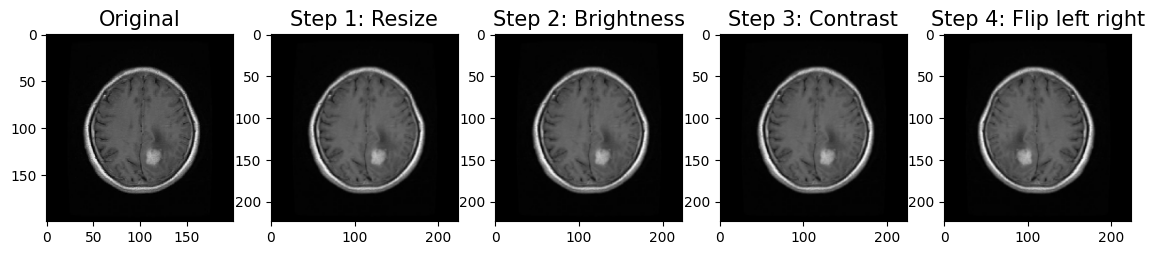

In [13]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [14]:
contrast = 3
DELTA = 0.3

def preprocess2(images_mini, y_mini, split= (0.8,0.2)):
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images_mini.shape[0]))
    images_mini, y_mini = images_mini[shuffle], y_mini[shuffle]
    
    #splits for validation
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val = np.split(images_mini, [splits[0]])
    y_train, y_val = np.split(y_mini, [splits[0]])
    
    #greyscaling
    X_train = X_train/255.0
    X_val = X_val/255.0
    
    #image augmentation
    X_train_augm = tf.image.adjust_brightness(X_train, delta = DELTA)
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor = contrast)
    
    #flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    #concatenate original and augmented
    X_train = tf.concat([X_train, X_train_augm], axis = 0)
    
    #concatenate y_train
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm], axis = 0)
    
    #Shuffle
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype = tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy()
    
    return X_train, y_train, X_val, y_val

In [15]:
X_train, y_train, X_val, y_val = preprocess2(
    images_mini,
    y_mini,
    split=(0.8,0.2)
)

In [20]:
#We have 5104 observations, each having 200x200 pixels, with each pixel having 3 values (which are all the same because they've been greyscaled)
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")

X_train shape (8826, 200, 200, 3)
y_train shape (8826,)
X_val shape (1104, 200, 200, 3)
y_val shape (1104,)


Print training data examples:


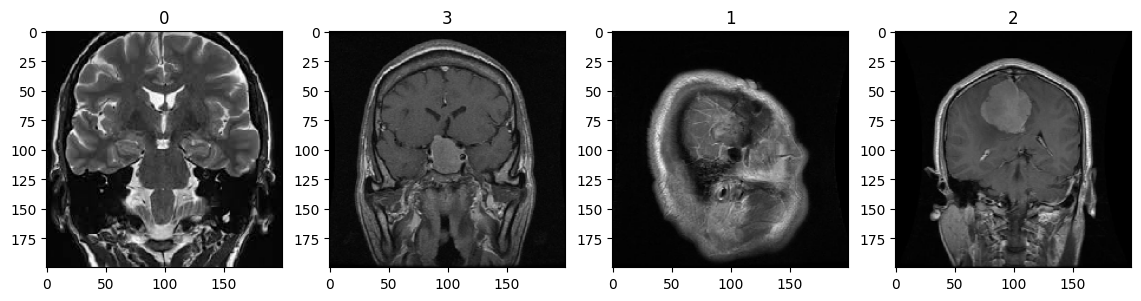

In [17]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


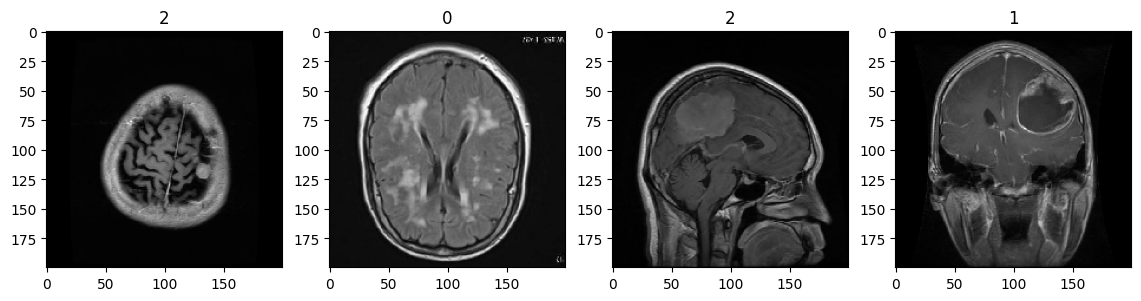

In [19]:
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

## Hyperparameter Tuning

#### 1 Convolutional Layer Models

Epoch 1/5
276/276 [==============================] - 339s 1s/step - loss: 2.7024 - sparse_categorical_accuracy: 0.7080 - val_loss: 0.5722 - val_sparse_categorical_accuracy: 0.8179
Epoch 2/5
276/276 [==============================] - 342s 1s/step - loss: 0.4185 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.3520 - val_sparse_categorical_accuracy: 0.8895
Epoch 3/5
276/276 [==============================] - 341s 1s/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.9004
Epoch 4/5
276/276 [==============================] - 343s 1s/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.2705 - val_sparse_categorical_accuracy: 0.9004
Epoch 5/5
276/276 [==============================] - 345s 1s/step - loss: 0.2061 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.2858 - val_sparse_categorical_accuracy: 0.8859


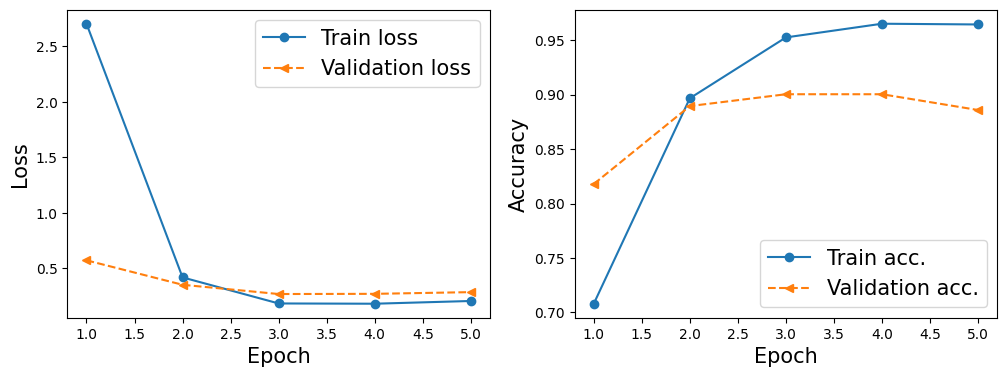

35/35 [==============================] - 4s 100ms/step
Epoch 1/5
276/276 [==============================] - 323s 1s/step - loss: 3.7477 - sparse_categorical_accuracy: 0.7098 - val_loss: 0.6571 - val_sparse_categorical_accuracy: 0.7880
Epoch 2/5
276/276 [==============================] - 319s 1s/step - loss: 0.3539 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.3483 - val_sparse_categorical_accuracy: 0.8949
Epoch 3/5
276/276 [==============================] - 318s 1s/step - loss: 0.2099 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.3497 - val_sparse_categorical_accuracy: 0.8732
Epoch 4/5
276/276 [==============================] - 318s 1s/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.2700 - val_sparse_categorical_accuracy: 0.9040
Epoch 5/5
276/276 [==============================] - 319s 1s/step - loss: 0.1121 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.2495 - val_sparse_categorical_accuracy: 0.9167


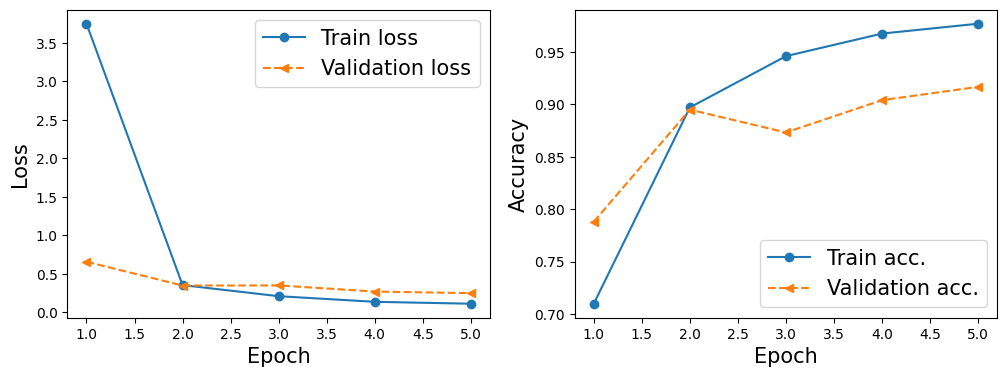

35/35 [==============================] - 4s 126ms/step
Epoch 1/5
276/276 [==============================] - 83s 300ms/step - loss: 0.9066 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.4685 - val_sparse_categorical_accuracy: 0.8723
Epoch 2/5
276/276 [==============================] - 83s 300ms/step - loss: 0.3517 - sparse_categorical_accuracy: 0.9011 - val_loss: 0.3168 - val_sparse_categorical_accuracy: 0.9058
Epoch 3/5
276/276 [==============================] - 83s 299ms/step - loss: 0.2339 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.3023 - val_sparse_categorical_accuracy: 0.9013
Epoch 4/5
276/276 [==============================] - 83s 299ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.2545 - val_sparse_categorical_accuracy: 0.9058
Epoch 5/5
276/276 [==============================] - 82s 299ms/step - loss: 0.1587 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.3045 - val_sparse_categorical_accuracy: 0.8913


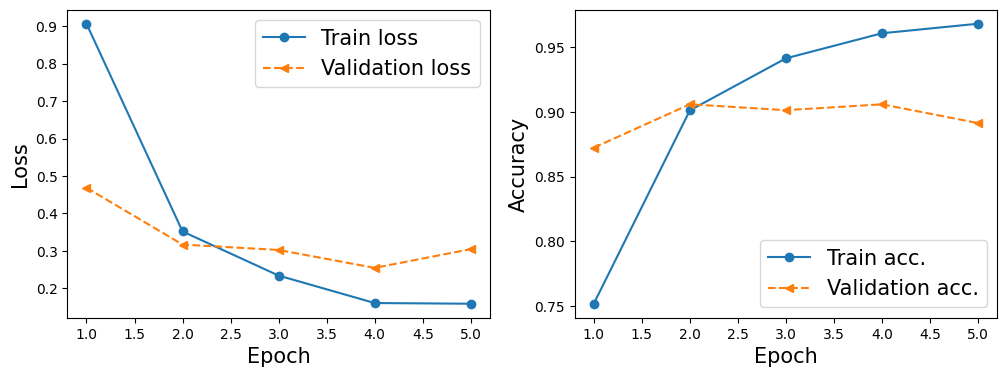

35/35 [==============================] - 1s 28ms/step
Epoch 1/5
276/276 [==============================] - 152s 550ms/step - loss: 1.6022 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.5302 - val_sparse_categorical_accuracy: 0.8324
Epoch 2/5
276/276 [==============================] - 152s 550ms/step - loss: 0.3946 - sparse_categorical_accuracy: 0.8860 - val_loss: 0.3613 - val_sparse_categorical_accuracy: 0.8922
Epoch 3/5
276/276 [==============================] - 152s 550ms/step - loss: 0.2100 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.2970 - val_sparse_categorical_accuracy: 0.8995
Epoch 4/5
276/276 [==============================] - 152s 551ms/step - loss: 0.1878 - sparse_categorical_accuracy: 0.9567 - val_loss: 0.2407 - val_sparse_categorical_accuracy: 0.9085
Epoch 5/5
276/276 [==============================] - 152s 552ms/step - loss: 0.1190 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.2335 - val_sparse_categorical_accuracy: 0.9158


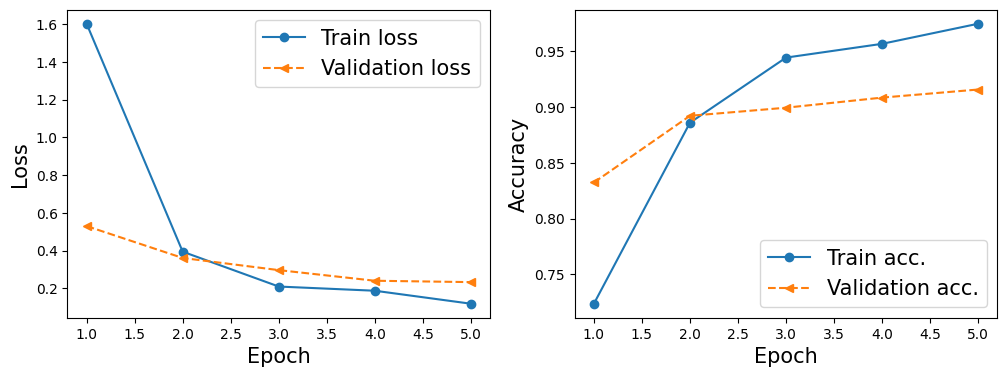

35/35 [==============================] - 2s 59ms/step
Epoch 1/5
276/276 [==============================] - 328s 1s/step - loss: 25.8124 - sparse_categorical_accuracy: 0.3927 - val_loss: 1.3825 - val_sparse_categorical_accuracy: 0.2690
Epoch 2/5
276/276 [==============================] - 321s 1s/step - loss: 1.5378 - sparse_categorical_accuracy: 0.5334 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.5888
Epoch 3/5
276/276 [==============================] - 323s 1s/step - loss: 19.2971 - sparse_categorical_accuracy: 0.4978 - val_loss: 0.9227 - val_sparse_categorical_accuracy: 0.6839
Epoch 4/5
276/276 [==============================] - 322s 1s/step - loss: 1.0067 - sparse_categorical_accuracy: 0.6352 - val_loss: 0.6287 - val_sparse_categorical_accuracy: 0.8098
Epoch 5/5
276/276 [==============================] - 322s 1s/step - loss: 0.8492 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.5406 - val_sparse_categorical_accuracy: 0.8288


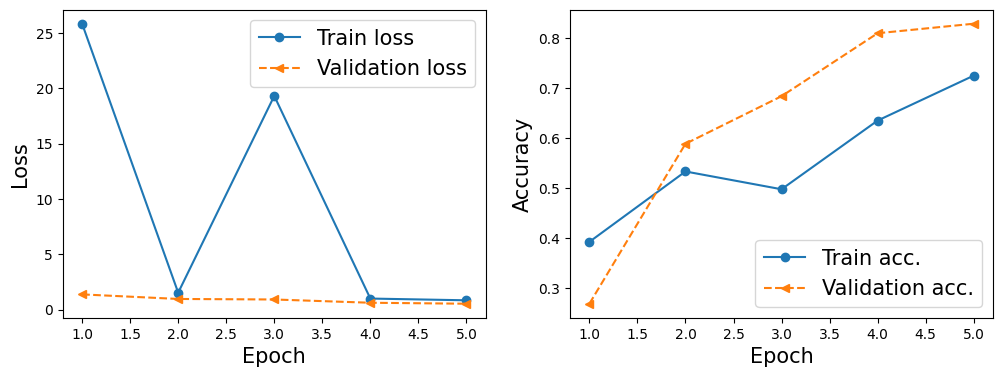

35/35 [==============================] - 3s 99ms/step
[0.9644232988357544, 0.9768864512443542, 0.9680489301681519, 0.9747337698936462, 0.7250170111656189]
[0.885869562625885, 0.9166666865348816, 0.8913043737411499, 0.91576087474823, 0.8288043737411499]
[0.9372822299651568, 0.9442508710801394, 0.9337979094076655, 0.9442508710801394, 0.9651567944250871]
[0.7555555555555555, 0.8814814814814815, 0.7148148148148148, 0.825925925925926, 0.7518518518518519]
[0.8429752066115702, 0.8429752066115702, 0.9008264462809917, 0.8801652892561983, 0.8471074380165289]
[0.9868852459016394, 0.980327868852459, 1.0, 0.9967213114754099, 0.7540983606557377]


In [25]:
kernel_sizes = [(5,5), (3,3), (5,5), (5,5), (5,5)]
strides_list = [(1,1), (1,1), (2,2), (1,1), (1,1)]
pool_sizes = [(2,2), (2,2), (2,2), (3,3), (2,2)]
learning_rates = [.001, .001, .001, .001, .01]
training_accuracies = []
validation_accuracies = []
recall_0 = []
recall_1 = []
recall_2 = []
recall_3 = []

for i in range(5):
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_1'))

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    # set units=4 to get a four output units (remember it's a multinomial classification problem)
    model.add(tf.keras.layers.Dense(
        units=4,
        name='fc_2',
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 200, 200, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rates[i]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=5, 
                        validation_data=(X_val, y_val)
    )
    #plotting loss and accuracy curves
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.savefig(f'Hyperparams/multi_1_layer_history_plot({i}).png', bbox_inches='tight')
    plt.show()
    
    #Saving training and validation accuracy
    training_accuracies.append(pd.DataFrame(hist)['sparse_categorical_accuracy'][4])
    validation_accuracies.append(pd.DataFrame(hist)['val_sparse_categorical_accuracy'][4])

    
    #Saving validation recall
    # get the predicted probabilities for the validation set
    y_pred = model.predict(X_val)
    y_val_pred = np.argmax(y_pred, axis=1)
    
    # compute the recall score for each class
    recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
    recall_0.append(recall_scores[0])
    recall_1.append(recall_scores[1])
    recall_2.append(recall_scores[2])
    recall_3.append(recall_scores[3])

print(training_accuracies)
print(validation_accuracies)
print(recall_0)
print(recall_1)
print(recall_2)
print(recall_3)

#### 2 Convolutional Layer Models

Epoch 1/5
276/276 [==============================] - 160s 580ms/step - loss: 0.7352 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.3953 - val_sparse_categorical_accuracy: 0.8714
Epoch 2/5
276/276 [==============================] - 158s 571ms/step - loss: 0.2666 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.2250 - val_sparse_categorical_accuracy: 0.9266
Epoch 3/5
276/276 [==============================] - 158s 572ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.9565 - val_loss: 0.2623 - val_sparse_categorical_accuracy: 0.9013
Epoch 4/5
276/276 [==============================] - 158s 571ms/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.1790 - val_sparse_categorical_accuracy: 0.9393
Epoch 5/5
276/276 [==============================] - 157s 570ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.2141 - val_sparse_categorical_accuracy: 0.9266


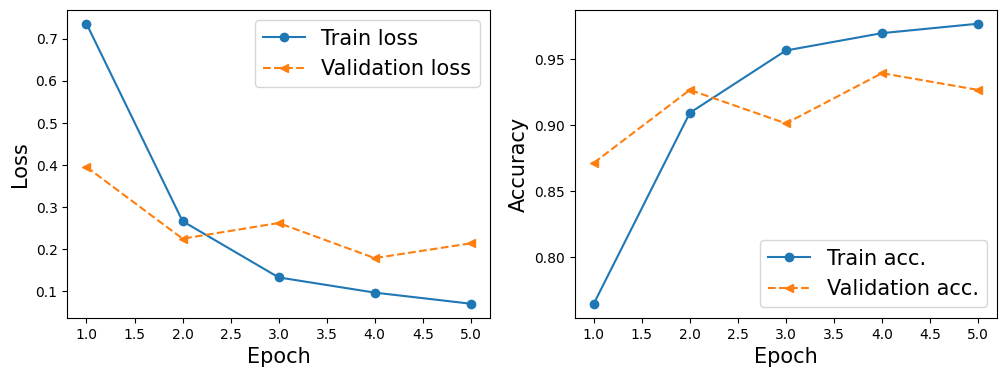

35/35 [==============================] - 2s 68ms/step
Epoch 1/5
276/276 [==============================] - 120s 432ms/step - loss: 0.9297 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.3831 - val_sparse_categorical_accuracy: 0.8668
Epoch 2/5
276/276 [==============================] - 119s 433ms/step - loss: 0.2248 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9158
Epoch 3/5
276/276 [==============================] - 120s 433ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.1881 - val_sparse_categorical_accuracy: 0.9266
Epoch 4/5
276/276 [==============================] - 120s 433ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.1882 - val_sparse_categorical_accuracy: 0.9384
Epoch 5/5
276/276 [==============================] - 120s 434ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.1700 - val_sparse_categorical_accuracy: 0.9402


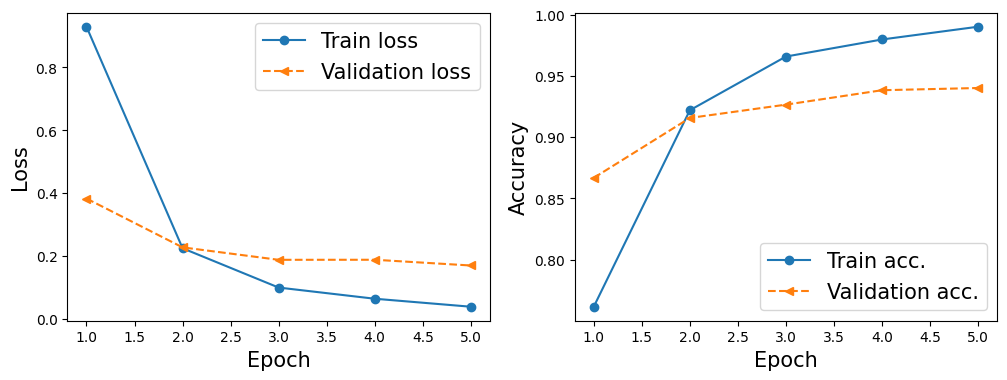

35/35 [==============================] - 2s 55ms/step
Epoch 1/5
276/276 [==============================] - 19s 67ms/step - loss: 0.7159 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.5410 - val_sparse_categorical_accuracy: 0.8107
Epoch 2/5
276/276 [==============================] - 18s 65ms/step - loss: 0.4358 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.3676 - val_sparse_categorical_accuracy: 0.8750
Epoch 3/5
276/276 [==============================] - 19s 70ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.2732 - val_sparse_categorical_accuracy: 0.9067
Epoch 4/5
276/276 [==============================] - 19s 67ms/step - loss: 0.2066 - sparse_categorical_accuracy: 0.9270 - val_loss: 0.2107 - val_sparse_categorical_accuracy: 0.9257
Epoch 5/5
276/276 [==============================] - 19s 67ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9492 - val_loss: 0.1967 - val_sparse_categorical_accuracy: 0.9321


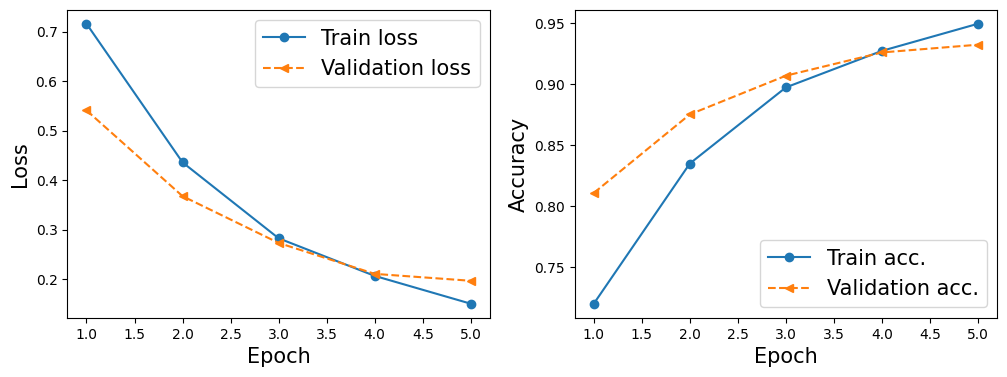

35/35 [==============================] - 1s 14ms/step
Epoch 1/5
276/276 [==============================] - 74s 265ms/step - loss: 0.6966 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.4347 - val_sparse_categorical_accuracy: 0.8587
Epoch 2/5
276/276 [==============================] - 72s 262ms/step - loss: 0.3466 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.2604 - val_sparse_categorical_accuracy: 0.9176
Epoch 3/5
276/276 [==============================] - 72s 262ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9139
Epoch 4/5
276/276 [==============================] - 72s 262ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.1864 - val_sparse_categorical_accuracy: 0.9429
Epoch 5/5
276/276 [==============================] - 72s 262ms/step - loss: 0.1076 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.2321 - val_sparse_categorical_accuracy: 0.9185


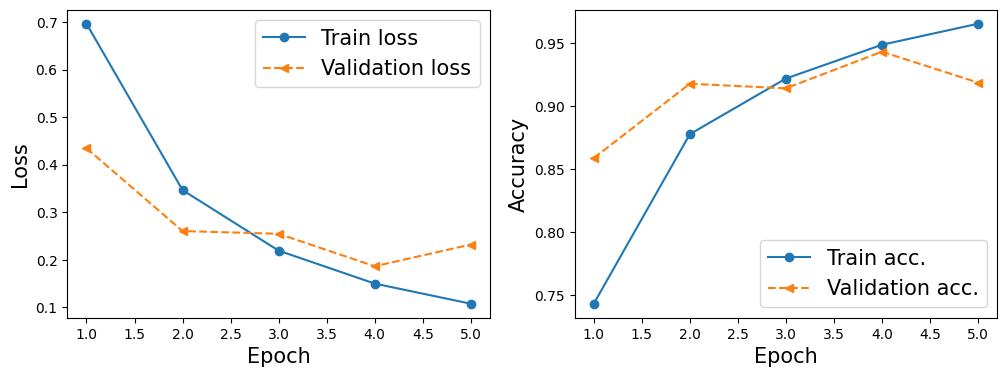

35/35 [==============================] - 1s 41ms/step
Epoch 1/5
276/276 [==============================] - 158s 570ms/step - loss: 3.5802 - sparse_categorical_accuracy: 0.2623 - val_loss: 1.3836 - val_sparse_categorical_accuracy: 0.2600
Epoch 2/5
276/276 [==============================] - 156s 565ms/step - loss: 1.3876 - sparse_categorical_accuracy: 0.2546 - val_loss: 1.3867 - val_sparse_categorical_accuracy: 0.2192
Epoch 3/5
276/276 [==============================] - 156s 566ms/step - loss: 1.3873 - sparse_categorical_accuracy: 0.2519 - val_loss: 1.3855 - val_sparse_categorical_accuracy: 0.2763
Epoch 4/5
276/276 [==============================] - 157s 570ms/step - loss: 1.3867 - sparse_categorical_accuracy: 0.2525 - val_loss: 1.3879 - val_sparse_categorical_accuracy: 0.2192
Epoch 5/5
276/276 [==============================] - 156s 567ms/step - loss: 1.3866 - sparse_categorical_accuracy: 0.2578 - val_loss: 1.3866 - val_sparse_categorical_accuracy: 0.2600


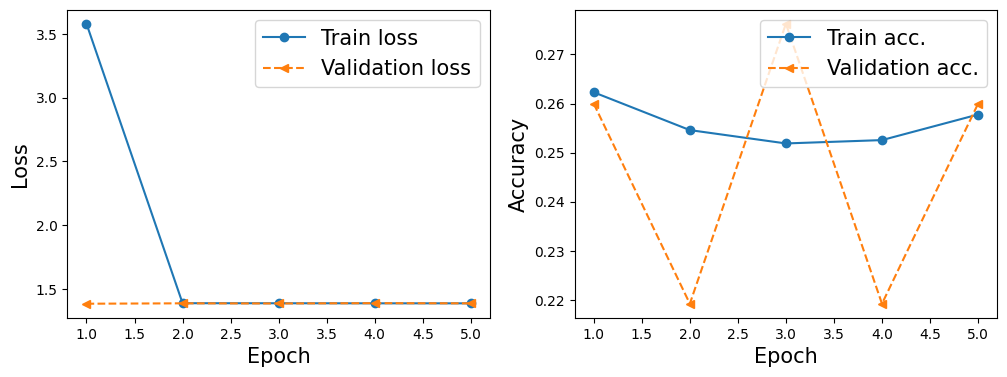

35/35 [==============================] - 3s 85ms/step
[0.9767731428146362, 0.9902560710906982, 0.9492408633232117, 0.9651030898094177, 0.257761150598526]
[0.926630437374115, 0.9402173757553101, 0.9320651888847351, 0.91847825050354, 0.2599637806415558]
[0.9477351916376306, 0.9512195121951219, 0.9477351916376306, 0.975609756097561, 1.0]
[0.8296296296296296, 0.8777777777777778, 0.8777777777777778, 0.7666666666666667, 0.0]
[0.9338842975206612, 0.9214876033057852, 0.9132231404958677, 0.9256198347107438, 0.0]
[0.9868852459016394, 1.0, 0.980327868852459, 0.9934426229508196, 0.0]


In [26]:
kernel_sizes = [(5,5), (3,3), (5,5), (5,5), (5,5)]
strides_list = [(1,1), (1,1), (2,2), (1,1), (1,1)]
pool_sizes = [(2,2), (2,2), (2,2), (3,3), (2,2)]
learning_rates = [.001, .001, .001, .001, .01]
training_accuracies = []
validation_accuracies = []
recall_0 = []
recall_1 = []
recall_2 = []
recall_3 = []

for i in range(5):
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer with pool size
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_1'))
    
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_2',
        activation='relu'))

    # add a max pooling layer with pool size
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_2'))
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    model.add(tf.keras.layers.Dense(
        units=4,
        name='fc_2',
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 200, 200, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rates[i]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=5, 
                        validation_data=(X_val, y_val)
    )
    #plotting
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.savefig(f'Hyperparams/multi_2_layer_history_plot({i}).png', bbox_inches='tight')
    plt.show()
    
    #Saving training and validation accuracy
    training_accuracies.append(pd.DataFrame(hist)['sparse_categorical_accuracy'][4])
    validation_accuracies.append(pd.DataFrame(hist)['val_sparse_categorical_accuracy'][4])

    
    #Saving validation recall
    # get the predicted probabilities for the validation set
    y_pred = model.predict(X_val)
    y_val_pred = np.argmax(y_pred, axis=1)
    
    # compute the recall score for each class
    recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
    recall_0.append(recall_scores[0])
    recall_1.append(recall_scores[1])
    recall_2.append(recall_scores[2])
    recall_3.append(recall_scores[3])

print(training_accuracies)
print(validation_accuracies)
print(recall_0)
print(recall_1)
print(recall_2)
print(recall_3)

#### 3 Convolutional Layer Models

Epoch 1/5
276/276 [==============================] - 136s 490ms/step - loss: 0.7112 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.5054 - val_sparse_categorical_accuracy: 0.8596
Epoch 2/5
276/276 [==============================] - 133s 482ms/step - loss: 0.3572 - sparse_categorical_accuracy: 0.8651 - val_loss: 0.2270 - val_sparse_categorical_accuracy: 0.9176
Epoch 3/5
276/276 [==============================] - 133s 481ms/step - loss: 0.2161 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.2252 - val_sparse_categorical_accuracy: 0.9230
Epoch 4/5
276/276 [==============================] - 133s 481ms/step - loss: 0.1299 - sparse_categorical_accuracy: 0.9541 - val_loss: 0.1492 - val_sparse_categorical_accuracy: 0.9529
Epoch 5/5
276/276 [==============================] - 133s 482ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.1390 - val_sparse_categorical_accuracy: 0.9574


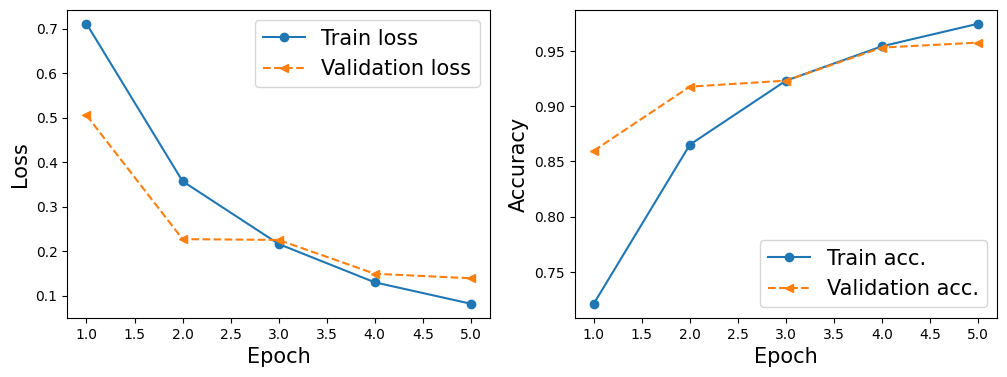

35/35 [==============================] - 2s 64ms/step
Epoch 1/5
276/276 [==============================] - 81s 290ms/step - loss: 0.7043 - sparse_categorical_accuracy: 0.7271 - val_loss: 0.4227 - val_sparse_categorical_accuracy: 0.8424
Epoch 2/5
276/276 [==============================] - 81s 294ms/step - loss: 0.3265 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.2431 - val_sparse_categorical_accuracy: 0.9167
Epoch 3/5
276/276 [==============================] - 81s 292ms/step - loss: 0.1857 - sparse_categorical_accuracy: 0.9334 - val_loss: 0.2180 - val_sparse_categorical_accuracy: 0.9293
Epoch 4/5
276/276 [==============================] - 80s 290ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.1715 - val_sparse_categorical_accuracy: 0.9447
Epoch 5/5
276/276 [==============================] - 80s 291ms/step - loss: 0.0677 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.1719 - val_sparse_categorical_accuracy: 0.9420


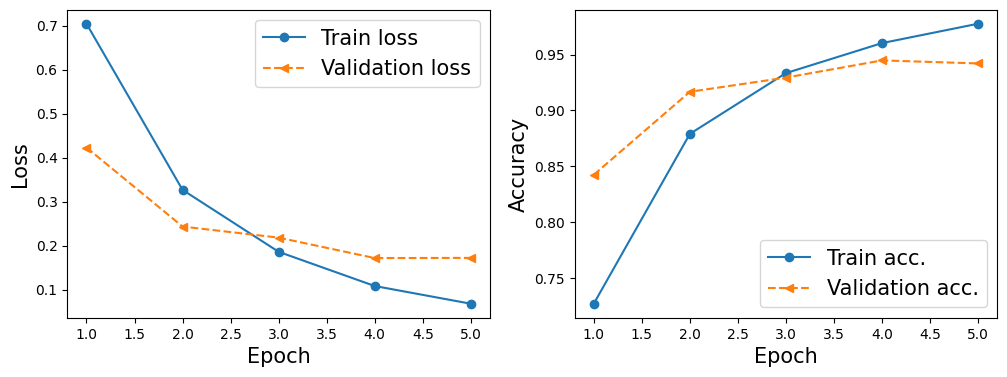

35/35 [==============================] - 2s 47ms/step
Epoch 1/5
276/276 [==============================] - 16s 57ms/step - loss: 0.8254 - sparse_categorical_accuracy: 0.6636 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.7654
Epoch 2/5
276/276 [==============================] - 16s 56ms/step - loss: 0.5125 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.4216 - val_sparse_categorical_accuracy: 0.8732
Epoch 3/5
276/276 [==============================] - 16s 56ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8678 - val_loss: 0.3518 - val_sparse_categorical_accuracy: 0.8786
Epoch 4/5
276/276 [==============================] - 16s 56ms/step - loss: 0.2627 - sparse_categorical_accuracy: 0.9039 - val_loss: 0.2776 - val_sparse_categorical_accuracy: 0.9076
Epoch 5/5
276/276 [==============================] - 16s 56ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.2386 - val_sparse_categorical_accuracy: 0.9239


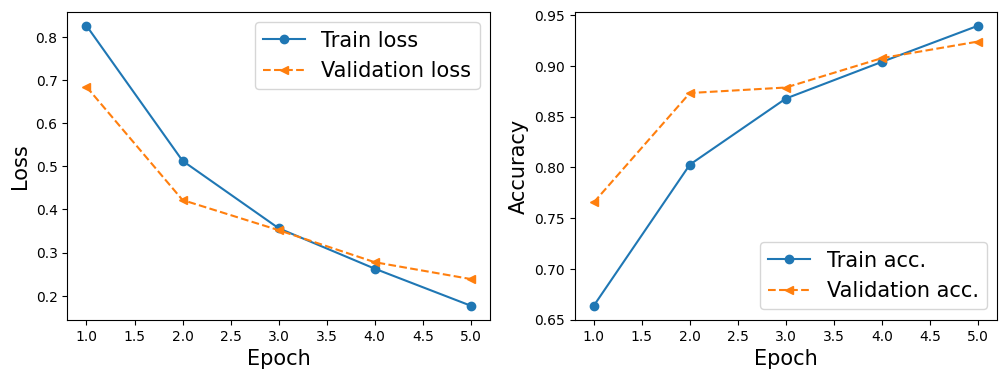

35/35 [==============================] - 1s 13ms/step
Epoch 1/5
276/276 [==============================] - 68s 246ms/step - loss: 0.7673 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.5659 - val_sparse_categorical_accuracy: 0.8043
Epoch 2/5
276/276 [==============================] - 68s 245ms/step - loss: 0.4523 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.3342 - val_sparse_categorical_accuracy: 0.8859
Epoch 3/5
276/276 [==============================] - 67s 242ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.2560 - val_sparse_categorical_accuracy: 0.9040
Epoch 4/5
276/276 [==============================] - 66s 240ms/step - loss: 0.2380 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.2116 - val_sparse_categorical_accuracy: 0.9312
Epoch 5/5
276/276 [==============================] - 66s 239ms/step - loss: 0.1823 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.1870 - val_sparse_categorical_accuracy: 0.9348


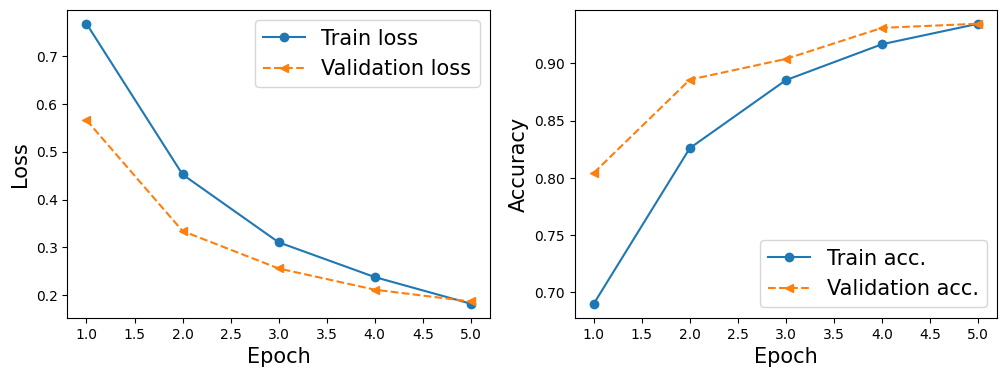

35/35 [==============================] - 1s 41ms/step
Epoch 1/5
276/276 [==============================] - 120s 432ms/step - loss: 2.1246 - sparse_categorical_accuracy: 0.2595 - val_loss: 1.3839 - val_sparse_categorical_accuracy: 0.2600
Epoch 2/5
276/276 [==============================] - 120s 433ms/step - loss: 1.3874 - sparse_categorical_accuracy: 0.2547 - val_loss: 1.3866 - val_sparse_categorical_accuracy: 0.2763
Epoch 3/5
276/276 [==============================] - 120s 433ms/step - loss: 1.3869 - sparse_categorical_accuracy: 0.2536 - val_loss: 1.3857 - val_sparse_categorical_accuracy: 0.2763
Epoch 4/5
276/276 [==============================] - 120s 434ms/step - loss: 1.3867 - sparse_categorical_accuracy: 0.2522 - val_loss: 1.3880 - val_sparse_categorical_accuracy: 0.2192
Epoch 5/5
276/276 [==============================] - 120s 434ms/step - loss: 1.3867 - sparse_categorical_accuracy: 0.2503 - val_loss: 1.3867 - val_sparse_categorical_accuracy: 0.2600


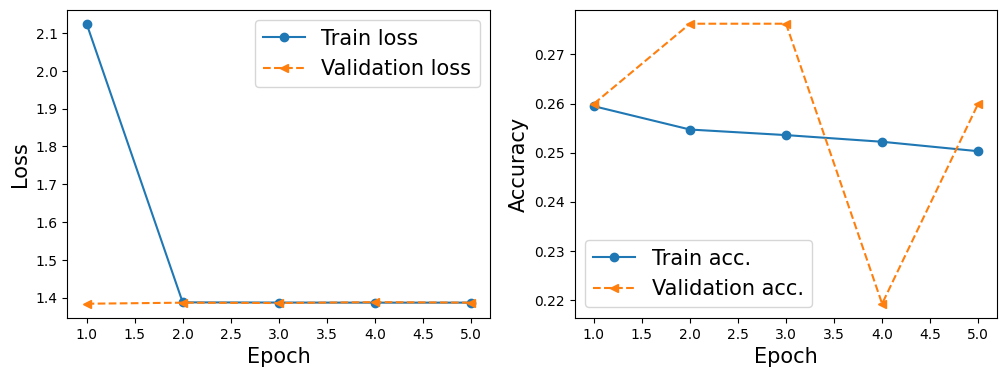

35/35 [==============================] - 2s 63ms/step
[0.9745071530342102, 0.9775663018226624, 0.9394969344139099, 0.934738278388977, 0.25028324127197266]
[0.9574275612831116, 0.9420289993286133, 0.9239130616188049, 0.9347826242446899, 0.2599637806415558]
[0.9547038327526133, 0.9512195121951219, 0.9651567944250871, 0.975609756097561, 1.0]
[0.9259259259259259, 0.8666666666666667, 0.8777777777777778, 0.8444444444444444, 0.0]
[0.9545454545454546, 0.9545454545454546, 0.8305785123966942, 0.9090909090909091, 0.0]
[0.9901639344262295, 0.9901639344262295, 1.0, 0.9967213114754099, 0.0]


In [27]:
kernel_sizes = [(5,5), (3,3), (5,5), (5,5), (5,5)]
strides_list = [(1,1), (1,1), (2,2), (1,1), (1,1)]
pool_sizes = [(2,2), (2,2), (2,2), (3,3), (2,2)]
learning_rates = [.001, .001, .001, .001, .01]
training_accuracies = []
validation_accuracies = []
recall_0 = []
recall_1 = []
recall_2 = []
recall_3 = []

for i in range(5):
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer with pool size 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_1'))
    
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_2',
        activation='relu'))

    # add a max pooling layer with pool size 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_2'))

    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_3',
        activation='relu'))

    # add a max pooling layer with pool size 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_3'))
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    model.add(tf.keras.layers.Dense(
        units=4,
        name='fc_2',
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 200, 200, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rates[i]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=5, 
                        validation_data=(X_val, y_val)
    )
    #plotting
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.savefig(f'Hyperparams/multi_3_layer_history_plot({i}).png', bbox_inches='tight')
    plt.show()
    
    #Saving training and validation accuracy
    training_accuracies.append(pd.DataFrame(hist)['sparse_categorical_accuracy'][4])
    validation_accuracies.append(pd.DataFrame(hist)['val_sparse_categorical_accuracy'][4])

    
    #Saving validation recall
    # get the predicted probabilities for the validation set
    y_pred = model.predict(X_val)
    y_val_pred = np.argmax(y_pred, axis=1)
    
    # compute the recall score for each class
    recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
    recall_0.append(recall_scores[0])
    recall_1.append(recall_scores[1])
    recall_2.append(recall_scores[2])
    recall_3.append(recall_scores[3])

print(training_accuracies)
print(validation_accuracies)
print(recall_0)
print(recall_1)
print(recall_2)
print(recall_3)

#### Model for enabling/disabling images flip

In [36]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size 
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)))

# add second max pooling layer with pool size (2,2)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)

# add third convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    name='conv_3',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)))

# add second max pooling layer with pool size (2,2) 
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_3')
)

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
model.add(tf.keras.layers.Dense(
    units=4,
    name='fc_2',
    activation='softmax'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 200, 200, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 100, 100, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 100, 100, 64)      18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 50, 50, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 50, 50, 64)        36928     
                                                                 
 pool_3 (MaxPooling2D)       (None, 25, 25, 64)        0         
                                                                 
 flatten (Flatten)           (None, 40000)             0

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 

In [38]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val)
)

Epoch 1/5
276/276 [==============================] - 112s 406ms/step - loss: 1.1664 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7764 - val_sparse_categorical_accuracy: 0.7908
Epoch 2/5
276/276 [==============================] - 113s 409ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.8850 - val_loss: 0.5217 - val_sparse_categorical_accuracy: 0.8868
Epoch 3/5
276/276 [==============================] - 113s 410ms/step - loss: 0.3112 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.4000 - val_sparse_categorical_accuracy: 0.9067
Epoch 4/5
276/276 [==============================] - 113s 411ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.3862 - val_sparse_categorical_accuracy: 0.8976
Epoch 5/5
276/276 [==============================] - 114s 412ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.3419 - val_sparse_categorical_accuracy: 0.9130


In [39]:
# get the predicted probabilities for the validation set
y_pred = model.predict(X_val)
y_val_pred = np.argmax(y_pred, axis=1)

# compute the recall score for each class
recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
recall_scores

35/35 [==============================] - 2s 64ms/step


array([0.93728223, 0.8988764 , 0.84229391, 0.97416974])

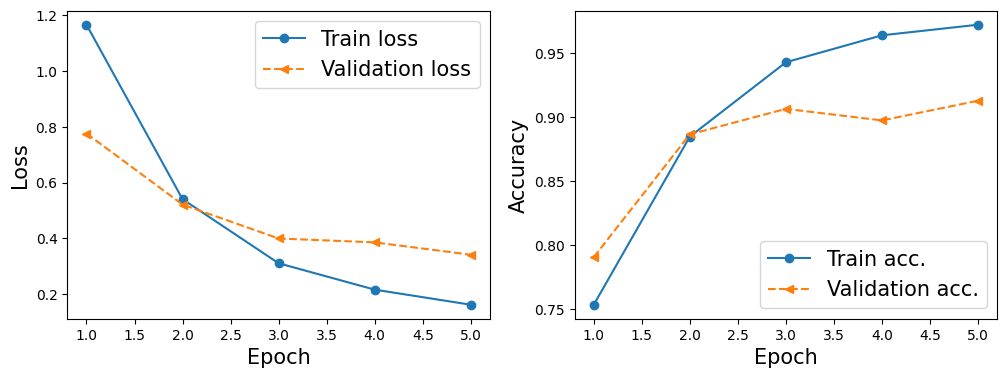

In [40]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.savefig('Hyperparams/multi_3_layer_history_plot(5).png', bbox_inches='tight')
plt.show()

## Hyperparameter results

1 Layer

|Training accuracy|Validation accuracy|Val. Recall 0|Val. Recall 1|Val. Recall 2|Val. Recall 3|       kernel size          |           strides          |           pool size        |         learning rate       |    flip_on_train   |
|:-:              |:-:                |:-:          |:-:          |:-:          |:-:          |:-:                         |:-:                         |:-:                         |:-:                          |:-:                 |
| 0.96            | 0.98              |0.97         |0.97         |0.84         |0.99         | 5,5                        | 1,1                        | 2,2                        | 0.001                       | yes                |
| 0.99            | 0.92              |0.89         |0.92         |0.84         |0.98         |<font color="red">3,3</font>| 1,1                        | 2,2                        | 0.001                       | yes                |
| 0.99            | 0.94              |0.93         |0.94         |0.90         |1.0          | 5,5                        |<font color="red">2,2</font>| 2,2                        | 0.001                       | yes                |
| 0.99            | 0.88              |0.71         |0.83         |0.88         |1.0          | 5,5                        | 1,1                        |<font color="red">3,3</font>| 0.001                       | yes                |
| 0.97            | 0.84              |0.90         |0.88         |0.85         |0.75         | 5,5                        | 1,1                        | 2,2                        |<font color="red">0.01</font>| yes                |
| 0.98            | 0.85              |0.87         |0.80         |0.75         |0.97         | 5,5                        | 1,1                        | 2,2                        | 0.001                       | <font color="red">no</font>|

2 Layer

|Training accuracy|Validation accuracy|Val. Recall 0|Val. Recall 1|Val. Recall 2|Val. Recall 3|       kernel size          |           strides          |           pool size        |         learning rate       |    flip_on_train   |
|:-:              |:-:                |:-:          |:-:          |:-:          |:-:          |:-:                         |:-:                         |:-:                         |:-:                          |:-:                 |
| 0.98            | 0.96              |0.96         |0.83         |0.93          |0.99          | 5,5                        | 1,1                        | 2,2                        | 0.001                       | yes                |
| 0.99            | 0.96              |0.96         |0.88          |0.92          |1.0          |<font color="red">3,3</font>| 1,1                        | 2,2                        | 0.001                       | yes                |
| 0.99            | 0.97              |0.96         |0.88          |0.91          |0.98          | 5,5                        |<font color="red">2,2</font>| 2,2                        | 0.001                       | yes                |
| 0.99            | 0.98              |0.98         |0.77          |0.93          |0.99          | 5,5                        | 1,1                        |<font color="red">3,3</font>| 0.001                       | yes                |
| 0.97            | 0.96              |0.96         |0.0          |0.0         |0.0          | 5,5                        | 1,1                        | 2,2                        |<font color="red">0.01</font>| yes                |
| 0.98            | 0.90              |0.94         |0.86          |0.88          |0.94          | 5,5                        | 1,1                        | 2,2                        | 0.001                       | <font color="red">no</font>|

3 Layer

|Training accuracy|Validation accuracy|Val. Recall 0|Val. Recall 1|Val. Recall 2|Val. Recall 3|       kernel size          |           strides          |           pool size        |         learning rate       |    flip_on_train   |
|:-:              |:-:                |:-:          |:-:          |:-:          |:-:          |:-:                         |:-:                         |:-:                         |:-:                          |:-:                 |
| 0.98            | 0.96              |0.96         |0.93          |0.95          |0.99          | 5,5                        | 1,1                        | 2,2                        | 0.001                       | yes                |
| 0.99            | 0.96              |0.96         |0.87          |0.95          |0.99          |<font color="red">3,3</font>| 1,1                        | 2,2                        | 0.001                       | yes                |
| 0.99            | 0.97              |0.96         |0.88          |0.83          |1.0          | 5,5                        |<font color="red">2,2</font>| 2,2                        | 0.001                       | yes                |
| 0.99            | 0.98              |0.98         |0.84          |0.91          |1.0          | 5,5                        | 1,1                        |<font color="red">3,3</font>| 0.001                       | yes                |
| 0.97            | 0.96              |0.96         |0.0          |0.0          |0.0         | 5,5                        | 1,1                        | 2,2                        |<font color="red">0.01</font>| yes                |
| 0.97            | 0.91              |0.94         |0.90          |0.84          |0.97          | 5,5                        | 1,1                        | 2,2                        | 0.001                       | <font color="red">no</font>|

# Model Selection

It seems like the best model is the 3 layer convolutional model that has the default hyperparameters.

The "best" hyperparameter is where the pool size is 3,3 with all else equal. This is because of its validation recall and because of its loss and accuracy plot.

In [16]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)))

# add second max pooling layer with pool size
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)

# add third convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_3',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)))

# add second max pooling layer with pool size
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_3')
)

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
model.add(tf.keras.layers.Dense(
    units=4,
    name='fc_2',
    activation='softmax'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 200, 200, 3))
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 

# set random seed to get reproductible results 
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 100, 100, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 100, 100, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 50, 50, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 50, 50, 64)        102464    
                                                                 
 pool_3 (MaxPooling2D)       (None, 25, 25, 64)        0         
                                                                 
 flatten (Flatten)           (None, 40000)             0

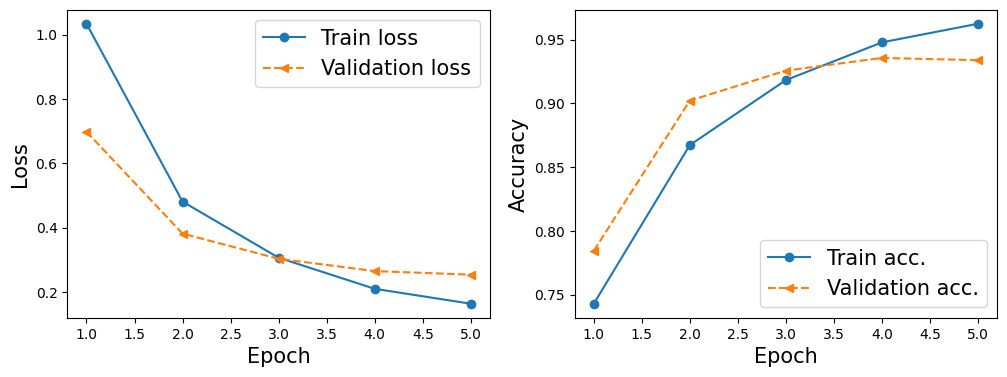

In [17]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [19]:
# get the predicted probabilities for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# calculate the AUC score
auc_score = metrics.roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"AUC score: {auc_score:.2f}")

41/41 [==============================] - 4s 96ms/step
AUC score: 0.99


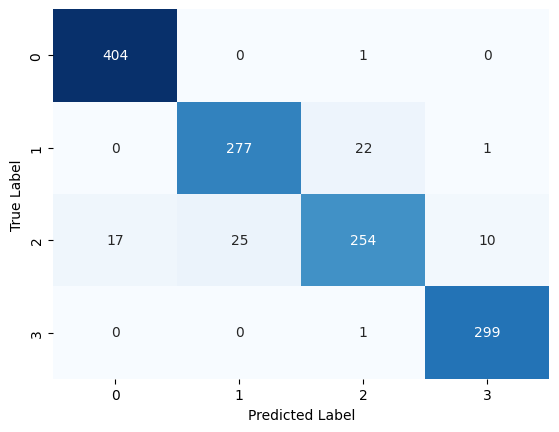

In [25]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [20]:
# compute the recall score for each class
recall_scores = metrics.recall_score(y_test, y_pred_labels, average=None)

# print the recall score for each class
print("Recall score for each class:")
for i in range(len(recall_scores)):
    print(f"Class {i}: {recall_scores[i]:.2f}")

Recall score for each class:
Class 0: 0.97
Class 1: 0.91
Class 2: 0.86
Class 3: 1.00


In [27]:
recall_scores = metrics.recall_score(y_test, y_pred_labels, average='macro')
recall_scores

0.9368990559186637

In [31]:
np.argmax(model.predict(X_test)[1], axis = 0)

41/41 [==============================] - 4s 94ms/step


0

In [18]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

41/41 [==============================] - 4s 95ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9314

Test Acc. 93.14%


## Model Interpretability 

Shape of image: (1, 200, 200, 3)


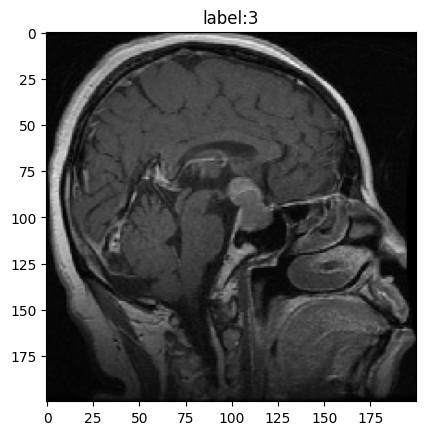

In [30]:
#Selecting one image for demonstration
img_idx= 85
#batches images, i.e. image[0,...,...]
img_tensor = np.expand_dims(X_val[img_idx], axis = 0);

# Print image tensor shape
print('Shape of image:', img_tensor.shape);

plt.imshow(img_tensor[0]);
plt.title('label:' + str(y_val[img_idx]))
plt.show()

#### Salient Mapping

In [31]:
#Turning image to float value
images = tf.Variable(img_tensor, dtype=float)

with tf.GradientTape() as tape:
    #pass images into model in evaluation mode
    pred = model(images, training=False)
    #get the sorted predicted class probabilities
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    #select class w/ highest probability
    loss = pred[0][class_idxs_sorted[0]]

#identifies gradients
grads = tape.gradient(loss, images)

In [32]:
#makes sure negative and positive values are considered
dgrad_abs = tf.math.abs(grads)
#getting the max gradient
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

In [33]:
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
#1e-18 to prevent zerodivision error
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

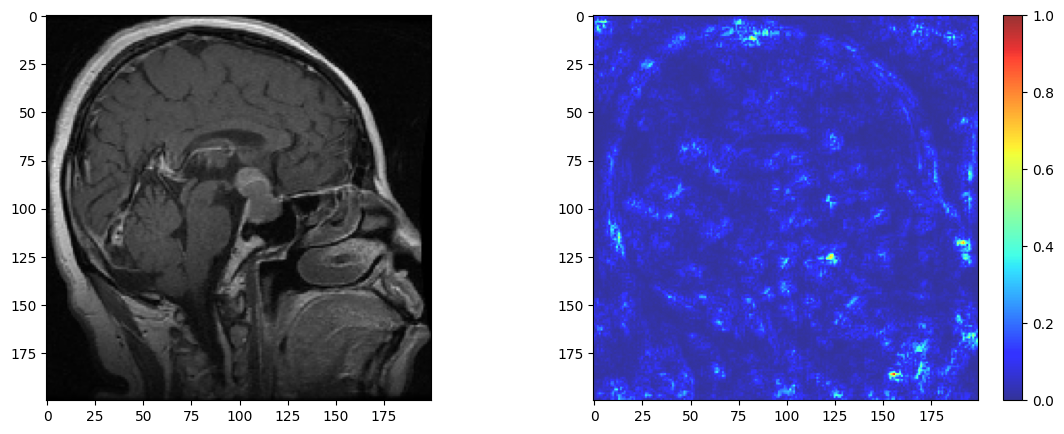

In [34]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(img_tensor[0])
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

#### Shap Values

In [35]:
# define the explainer
explainer = shap.GradientExplainer(model, X_train.numpy())

# we explain the model's predictions on the validation image at index==img_idx
shap_values = explainer.shap_values(X_val[img_idx:img_idx+1])

array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00784314, 0.00784314, 0.00784314],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.01568628, 0.01568628, 0.01568628],
         [0.01960784, 0.01960784, 0.01960784],
         [0.03137255, 0.03137255, 0.03137255],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


35/35 [==============================] - 3s 93ms/step


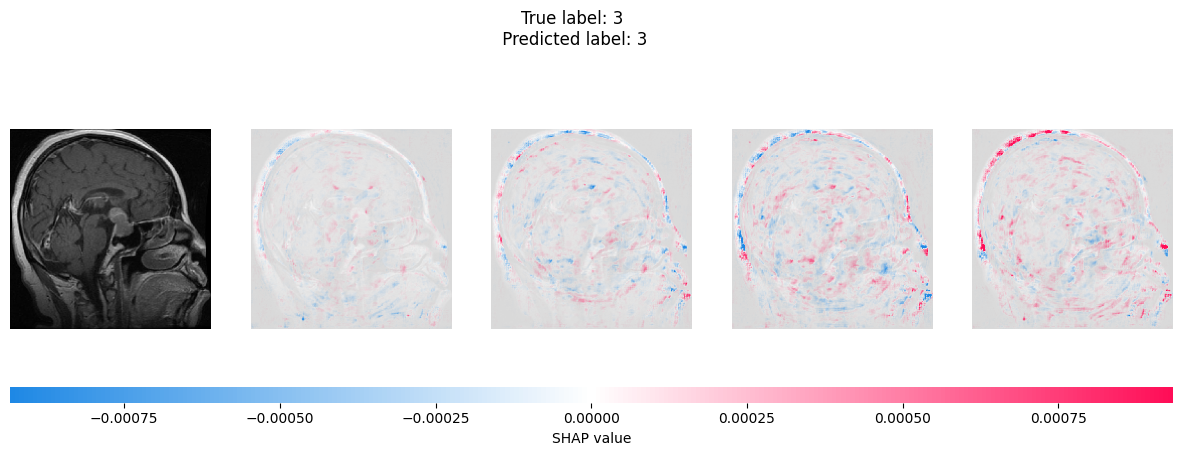

In [36]:
# plot the explanations for all classes 
shap.image_plot(
    [shap_values[i][0] for i in range(4)],
    np.squeeze(X_val[img_idx]),
    show=False
)

# compute predicted label for X_val[img_idx]
probs = model.predict(X_val)[img_idx]
y_val_pred_img_idx = np.argmax(probs)

# add title
plt.suptitle(
    'True label: ' + str(y_val[img_idx]) +
    '\n Predicted label: ' + str(y_val_pred_img_idx));

## Saving / Loading Models

In [19]:
#model.save('CNN_model')

INFO:tensorflow:Assets written to: CNN_model\assets


INFO:tensorflow:Assets written to: CNN_model\assets


In [21]:
#model = tf.keras.models.load_model('saved_models/multinomial_CNN/')
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 100, 100, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 50, 50, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 25, 25, 64)        0         
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              40961024  
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [22]:
#test_results = model.evaluate(X_test, y_test)
#print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

41/41 [==============================] - 2s 47ms/step - loss: 0.2830 - sparse_categorical_accuracy: 0.9390

Test Acc. 93.90%
